In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import mean_squared_error
import math

sns.set_style('whitegrid')

matplotlib.rcParams.update({'font.size':20})

def rmse(y, y_hat):
    return np.sqrt(mean_squared_error(y, y_hat))


In [2]:
df = pd.read_excel("Sample - Superstore.xls")
df.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,3,CA-2016-138688,2016-06-12,2016-06-16,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
3,4,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
4,5,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164


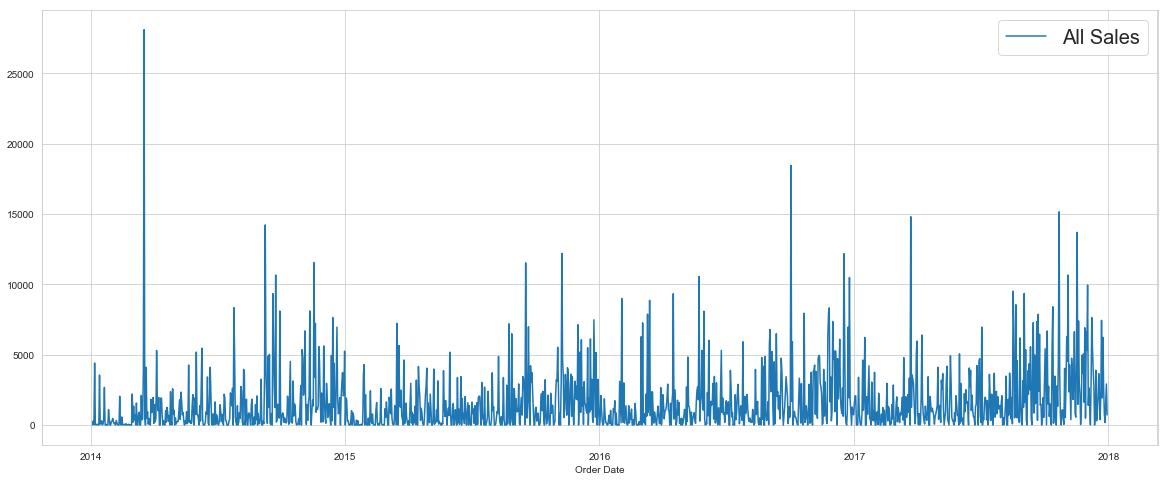

In [3]:
# There is a lot of data and it needs to be summarized
fig, ax = plt.subplots(figsize = (20,8))

x = df.set_index('Order Date')['Sales'].index
y = df.set_index('Order Date')['Sales'].values

df.set_index('Order Date')['Sales'].resample('D').sum().plot(ax=ax, label='All Sales')
ax.legend(fontsize=20)
fig.savefig('img_allsales.png')

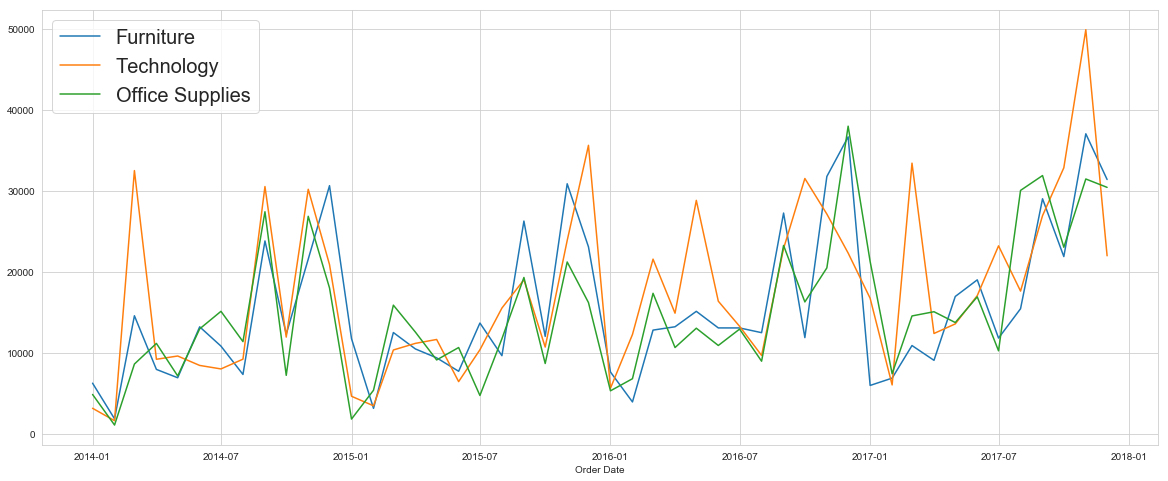

In [4]:
#df[df['Category'] == 'Furniture']['Sales'].plot()
furniture = df[df['Category'] == 'Furniture']
office_supplies = df[df['Category'] == 'Office Supplies']
technology = df[df['Category'] == 'Technology']

furniture = furniture.set_index('Order Date')
office_supplies = office_supplies.set_index('Order Date')
technology = technology.set_index('Order Date')

#plt.figure(figsize=(20,8))

fig, ax = plt.subplots(figsize=(20,8))


x_f = furniture['Sales'].resample('MS').sum().index
y_f = furniture['Sales'].resample('MS').sum().values

x_t = technology['Sales'].resample('MS').sum().index
y_t = technology['Sales'].resample('MS').sum().values

x_o = office_supplies['Sales'].resample('MS').sum().index
y_o = office_supplies['Sales'].resample('MS').sum().values


_ = sns.lineplot(x=x_f, y=y_f, ax=ax, label='Furniture')
_ = sns.lineplot(x=x_t, y=y_t, ax=ax, label='Technology')
_ = sns.lineplot(x=x_o, y=y_o, ax=ax, label='Office Supplies')

_ = ax.legend(fontsize=20)

fig.savefig('img_salesbycategory.png')


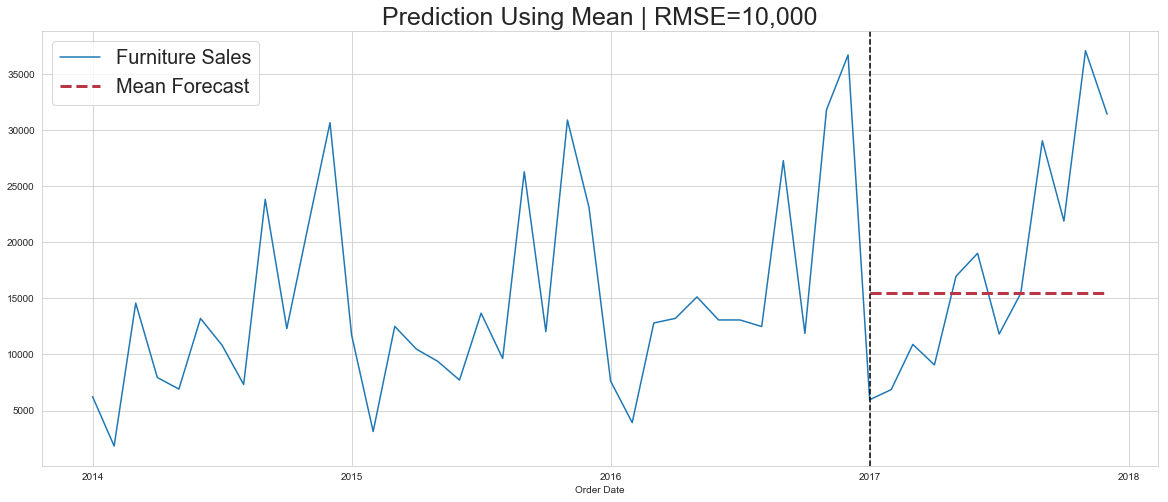

In [5]:
# Mean Prediction

furniture = df[df['Category'] == 'Furniture']
furniture = furniture.set_index('Order Date')
furniture = furniture['Sales'].resample('MS').sum()

pred_sales = np.mean(furniture.values)

pred = pd.Series(index = pd.date_range(start='01-01-2017', periods=12, freq='MS'))

for k, i in pred.iteritems():
    pred[k] = pred_sales

title = 'Prediction Using Mean | RMSE={:,.0f}'.format(rmse(furniture['2017'], pred))

fig, ax = plt.subplots(figsize=(20,8))
ax.set_title(title, fontsize=25)

furniture.plot(ax=ax, label='Furniture Sales')
pred.plot(linestyle='--', color='#B73844', linewidth=3, ax=ax, label='Mean Forecast')
ax.axvline(x=pred.index.min(), linestyle='--', color='black')
ax.legend(fontsize=20)

fig.savefig('img_mean_prediction.png')

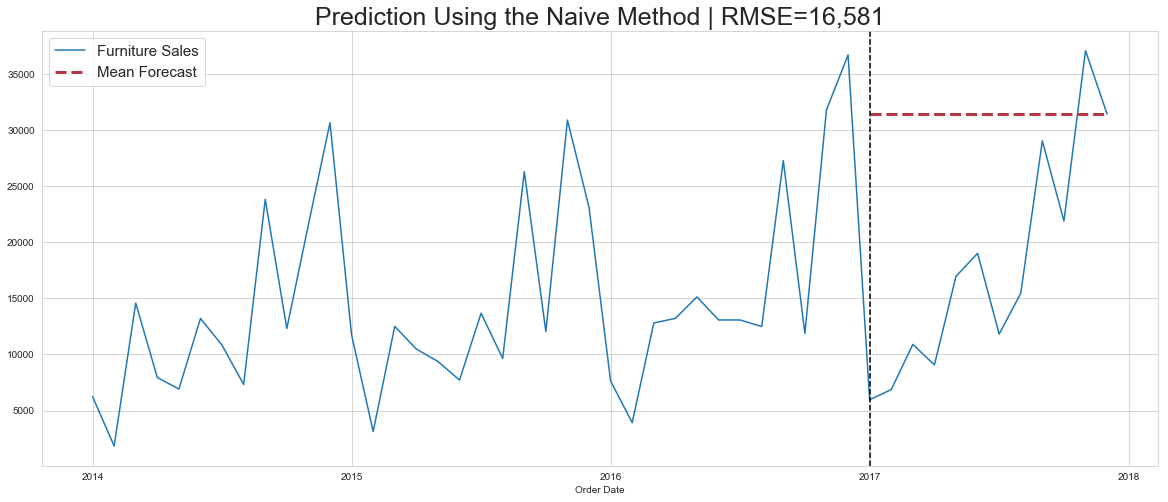

In [6]:
# Naive Method

furniture = df[df['Category'] == 'Furniture']
furniture = furniture.set_index('Order Date')
furniture = furniture['Sales'].resample('MS').sum()

pred_sales = furniture.values[-1]

pred = pd.Series(index = pd.date_range(start='01-01-2017', periods=12, freq='MS'))

for k, i in pred.iteritems():
    pred[k] = pred_sales

title = 'Prediction Using the Naive Method | RMSE={:,.0f}'.format(rmse(furniture['2017'], pred))
    
fig, ax = plt.subplots(figsize=(20,8))
ax.set_title(title, fontsize=25)

furniture.plot(ax=ax, label='Furniture Sales')
pred.plot(linestyle='--', color='#B73844', linewidth=3, ax=ax, label='Mean Forecast')
ax.axvline(x=pred.index.min(), linestyle='--', color='black')
ax.legend(fontsize=15)
fig.savefig('img_naive_prediction.png')

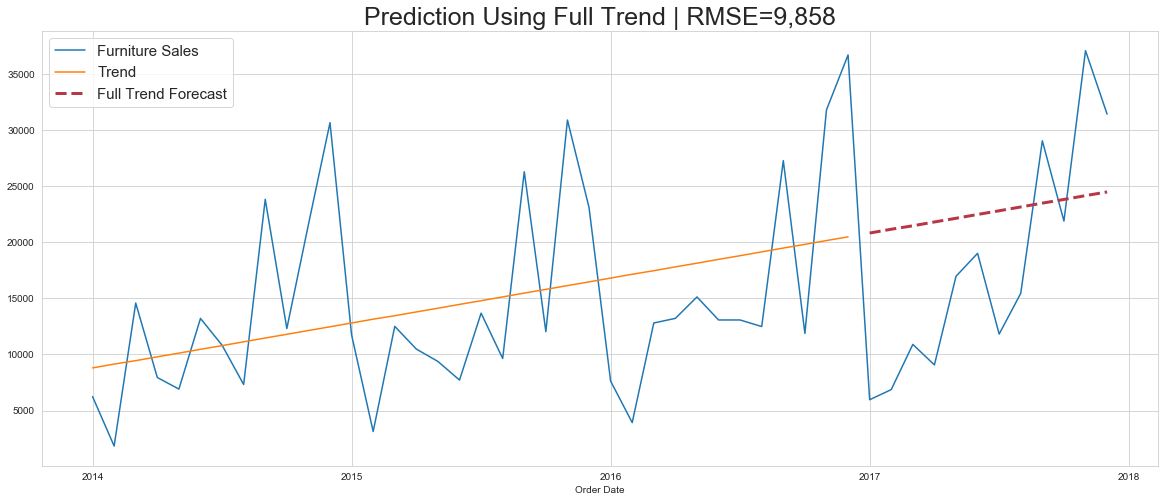

In [7]:
# Linear Trend
# Prior Year
# All Years

# Seasonal Naive Method

import matplotlib.dates as mdates 

furniture = df[df['Category'] == 'Furniture']
furniture = furniture.set_index('Order Date')
furniture = furniture['Sales'].resample('MS').sum()

x = mdates.date2num(furniture['2014':'2016'].index)

a = furniture['2014':'2016'].values
z = np.polyfit(x, a, 1)
p = np.poly1d(z)
#plt.plot(x, p(x))

trend = pd.Series(index=furniture['2014':'2016'].index, data=p(x))



# Prediction 
index = pd.date_range(start='01-01-2017', periods=12, freq='MS')

x = mdates.date2num(index)
pred = pd.Series(data=p(x), index=index)

title = 'Prediction Using Full Trend | RMSE={:,.0f}'.format(rmse(furniture['2017'], pred))

fig, ax = plt.subplots(figsize=(20,8))
ax.set_title(title, fontsize=25)

furniture.plot(ax=ax, label='Furniture Sales')
trend.plot(ax=ax, label='Trend')
pred.plot(linestyle='--', color='#B73844', linewidth=3, ax=ax, label='Full Trend Forecast')
ax.legend(fontsize=15)
fig.savefig('img_full_trend_forecast.png')

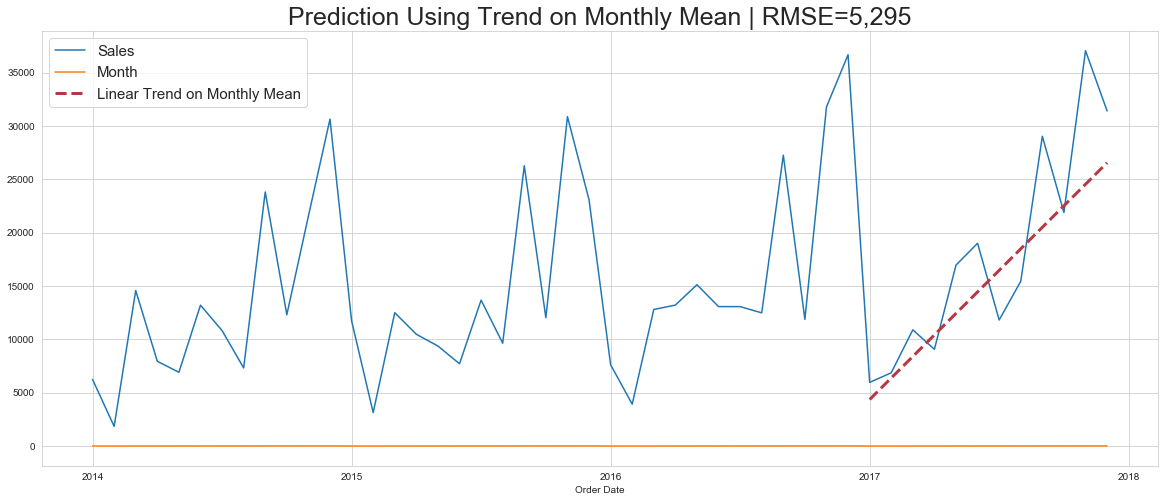

In [8]:
#Trend on Monthly Mean

furniture = df[df['Category'] == 'Furniture']
furniture = furniture.set_index('Order Date')
furniture = furniture['Sales'].resample('MS').sum()

pred_sales = furniture.values[-1]

furniture = pd.DataFrame(furniture)
furniture['Month'] = furniture.index.month
furniture.head()
s = furniture.groupby('Month')['Sales'].mean()

x = s.index
y = s.values
f = np.polyfit(x,y,1)
p = np.poly1d(f)

pred = pd.Series(data = p(x), index = pd.date_range(start='01-01-2017', periods=12, freq='MS'))

title = 'Prediction Using Trend on Monthly Mean | RMSE={:,.0f}'.format(rmse(furniture['2017']['Sales'], pred))
    
fig, ax = plt.subplots(figsize=(20,8))
ax.set_title(title, fontsize=25)

furniture.plot(ax=ax, label='Furniture Sales')
pred.plot(linestyle='--', color='#B73844', linewidth=3, ax=ax, label='Linear Trend on Monthly Mean')
ax.legend(fontsize=15)
fig.savefig('img_mean_monthly_linear_trend_forecast.png')

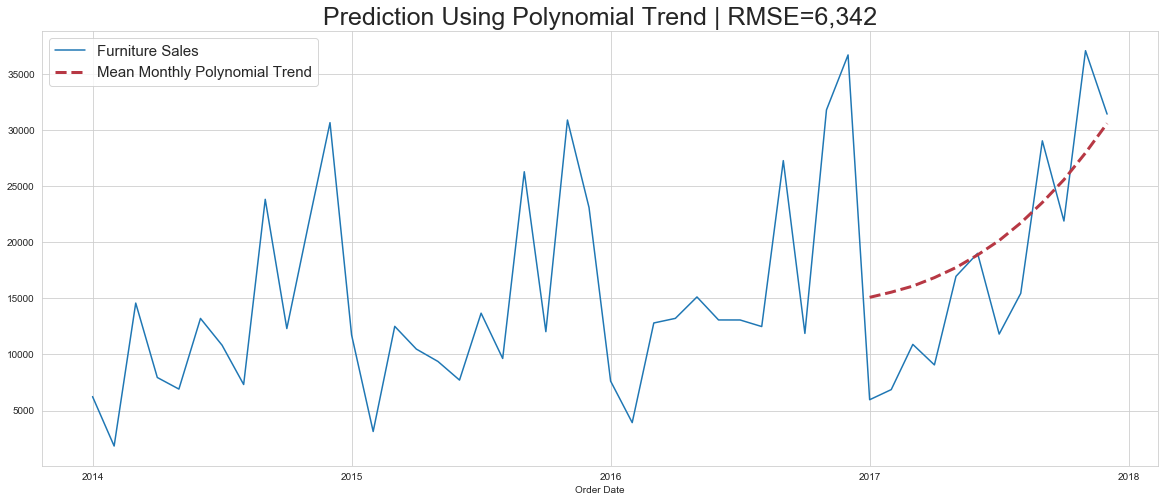

In [9]:
# Polynomial Trend Forecast
# Prior Year
# All Years

# Seasonal Naive Method

import matplotlib.dates as mdates 

furniture = df[df['Category'] == 'Furniture']
furniture = furniture.set_index('Order Date')
furniture = furniture['Sales'].resample('MS').sum()

x = mdates.date2num(furniture.index)

a = furniture.values
z = np.polyfit(x, a, 5)
p = np.poly1d(z)

trend = pd.Series(index=furniture.index, data=p(x))

# Prediction 
index = pd.date_range(start='01-01-2017', periods=12, freq='MS')

x = mdates.date2num(index)
pred = pd.Series(data=p(x), index=index)

title = 'Prediction Using Polynomial Trend | RMSE={:,.0f}'.format(rmse(furniture['2017'], pred))

fig, ax = plt.subplots(figsize=(20,8))
ax.set_title(title, fontsize=25)

furniture.plot(ax=ax, label='Furniture Sales')
pred.plot(linestyle='--', color='#B73844', linewidth=3, ax=ax, label='Mean Monthly Polynomial Trend')
ax.legend(fontsize=15)
fig.savefig('img_mean_monthly_polynomial_trend_forecast.png')

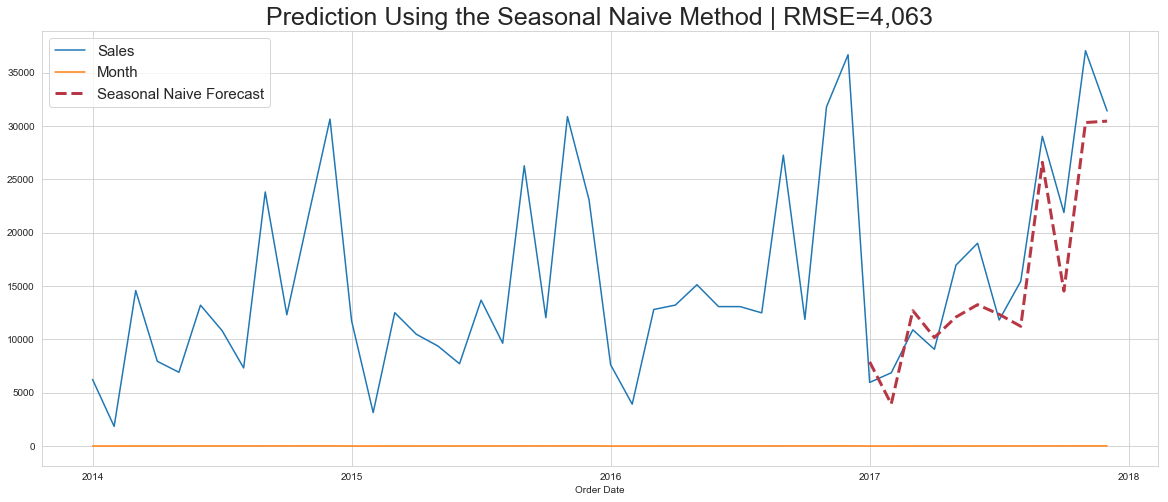

In [10]:
# Seasonal Naive Method

furniture = df[df['Category'] == 'Furniture']
furniture = furniture.set_index('Order Date')
furniture = furniture['Sales'].resample('MS').sum()

pred_sales = furniture.values[-1]

pred = pd.Series(index = pd.date_range(start='01-01-2017', periods=12, freq='MS'))


furniture = pd.DataFrame(furniture)
furniture['Month'] = furniture.index.month
furniture.head()
s = furniture.groupby('Month')['Sales'].mean()
s.index = pred.index

for k, i in pred.iteritems():
    pred[k] = s[k]

title = 'Prediction Using the Seasonal Naive Method | RMSE={:,.0f}'.format(rmse(furniture['2017']['Sales'], pred))
    
fig, ax = plt.subplots(figsize=(20,8))
ax.set_title(title, fontsize=25)

furniture.plot(ax=ax, label='Furniture Sales')
#pred.plot(style='b--', ax=ax, label='Naive Seasonal Forecast')
pred.plot(linestyle='--', color='#B73844', linewidth=3, ax=ax, label='Seasonal Naive Forecast')
ax.legend(fontsize=15)
fig.savefig('img_seasonal_naive_forecast.png')


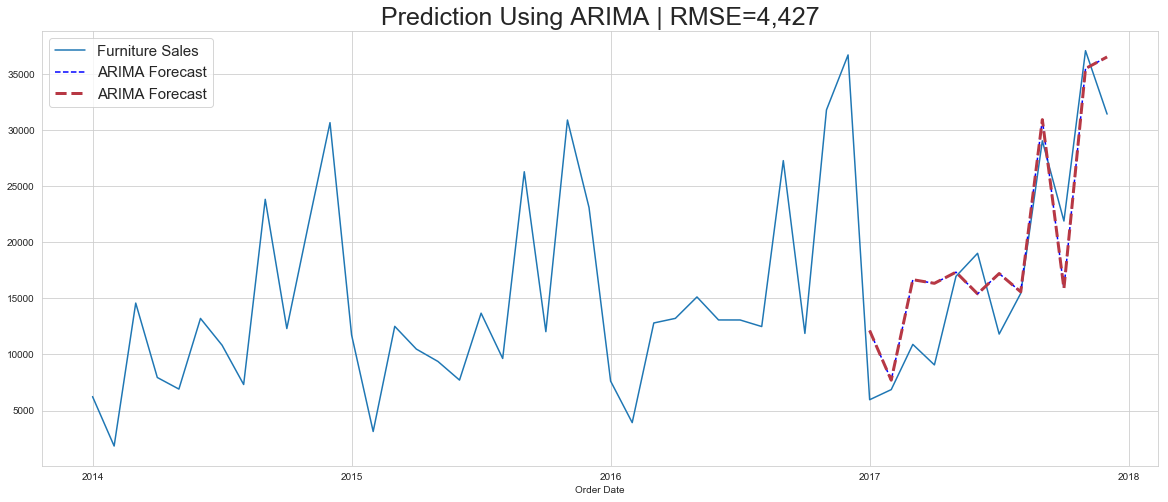

In [11]:
# ARIMA Model

furniture = df[df['Category'] == 'Furniture']
furniture = furniture.set_index('Order Date')
furniture = furniture['Sales'].resample('MS').sum()

fit1 = sm.tsa.statespace.SARIMAX(furniture, 
                                 order=(1, 1, 1),
                                 seasonal_order=(1,1,0,12), 
                                 enforce_stationarity=False,
                                 enforce_invertibility=False).fit()

index = pd.date_range(start='2018', periods=12, freq='MS')


pred = fit1.predict(start='2017-01-01', end='2017-12-01', dynamic=True)

title = 'Prediction Using ARIMA | RMSE={:,.0f}'.format(rmse(furniture['2017'], pred))
    
fig, ax = plt.subplots(figsize=(20,8))
ax.set_title(title, fontsize=25)

furniture.plot(ax=ax, label='Furniture Sales')
pred.plot(style='b--', ax=ax, label='ARIMA Forecast')
pred.plot(linestyle='--', color='#B73844', linewidth=3, ax=ax, label='ARIMA Forecast')
ax.legend(fontsize=15)
fig.savefig('img_arima_forecast.png')

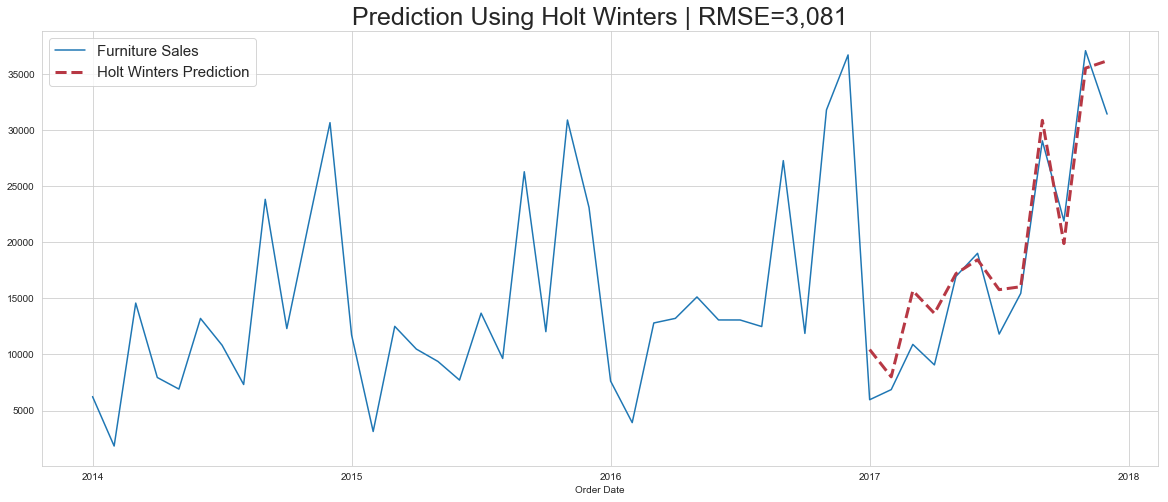

In [12]:
# Holt Winters
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.api import Holt, SimpleExpSmoothing

furniture = df[df['Category'] == 'Furniture']
furniture = furniture.set_index('Order Date')
furniture = furniture['Sales'].resample('MS').sum()

fit2 = Holt(np.asarray(furniture)).fit(smoothing_level = 0.3,smoothing_slope = 0.1)

#plt.plot(fit2.forecast(10))

fit1 = ExponentialSmoothing(furniture ,seasonal_periods=12 ,trend='add', seasonal='add',).fit()

index = pd.date_range(start='2017', periods=12, freq='MS')
data = fit1.forecast(12).values
pred = pd.Series(index=index, data=data)



furniture = df[df['Category'] == 'Furniture']
furniture = furniture.set_index('Order Date')
furniture = furniture['Sales'].resample('MS').sum()


title = 'Prediction Using Holt Winters | RMSE={:,.0f}'.format(rmse(furniture['2017'], pred))
    
fig, ax = plt.subplots(figsize=(20,8))
ax.set_title(title, fontsize=25)

furniture.plot(ax=ax, label='Furniture Sales')
#pred.plot(style='b--', ax=ax, label='Holt Winters Prediction')
pred.plot(linestyle='--', color='#B73844', linewidth=3, ax=ax, label='Holt Winters Prediction')
ax.legend(fontsize=15)
fig.savefig('img_holt_winters_forecast.png')

In [13]:
# Tune Arima

from itertools import product

p = d = q = range(0,2)
pdq = list(product(p,d,q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(product(p,d,q))]

for p1 in pdq:
    for p2 in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(furniture,
                                            order=p1,
                                            seasonal_order=p2,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(p1, p2, results.aic))
            
        except:
            continue
            

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:1056.7150862281565
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1466.9610577217322
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:691.3931482484253
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:711.2492842040824
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1574.711856308896
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:475.92673489624383
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:1015.7594088766147
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:5357.395646255874
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:674.6304760632347
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:779.6594254270542
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:15355827.6267757
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:476.78163414148753
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:984.8655318416035
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:1253.9681302367949
ARIMA(0, 1, 0)x(0, 1, 0, 12)12 - AIC:695.1954904555535
ARIMA(0, 1, 0)x(1, 0, 0, 12)12 - AIC:714.9998830715462
ARIMA(0, 1, 0)x(1, 0, 1, 12)12 - AIC:1267.45140823629
ARIMA(0, 1, 0)x(1, 1, 0, 12)12 - AIC:465.69545058897455
ARIMA

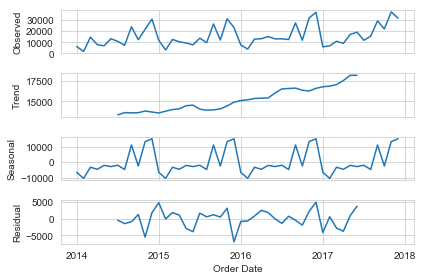

In [14]:
# Decompose a timeseries
decomposition = sm.tsa.seasonal_decompose(furniture, model='additive')
fig = decomposition.plot()
plt.show()